# Libraries + Settings

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from google.colab import drive
import seaborn as sns
import plotly.express as px
import missingno as msno

np.set_printoptions(precision=3, suppress=True) # set number format for printing
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
np.random.seed(100)

# Mineral Volume

## Problem Setup

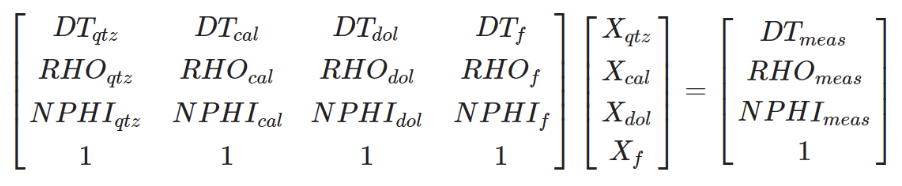

## Constants

In [61]:
# Coefficient matrix
A = np.array([[55.5, 47.5, 43.5, 189.], [2.65, 2.7, 2.8, 1.05], [-0.04, 0., 0.05, 1.], [1., 1., 1., 1.]])
(m, n) = A.shape

# DT range
dt = [np.min(A[0,:]), np.max(A[0,:])]

# RHOB range
rhob = [np.min(A[1,:]), np.max(A[1,:])]

# NPHI range
nphi = [np.min(A[2,:]), np.max(A[2,:])]

# depth data
depth = np.arange(0, 6000, 1000)

# Constant matrix
b_data = np.zeros((m, len(depth)), dtype=np.float32)
b_data[-1, :] = 1

# Variable matrix
x_sol = np.zeros((n, len(depth)), dtype=np.float32)

print(A,'\n\n')
print(b_data)

[[ 55.5   47.5   43.5  189.  ]
 [  2.65   2.7    2.8    1.05]
 [ -0.04   0.     0.05   1.  ]
 [  1.     1.     1.     1.  ]] 


[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]]


## Objective Function

In [62]:
def objective(x, A, b):
    return np.sum((A @ x - b)**2)

## Generate Data

In [63]:
# Generate random DT, RHOB, and NPHI at each depth

for i in range(len(depth)):
  b_data[0, i] = np.random.uniform(dt[0], dt[1])
  b_data[1, i] = np.random.uniform(rhob[0], rhob[1])
  b_data[2, i] = np.random.uniform(nphi[0], nphi[1])

print(b_data)

[[122.565 166.415 141.094 127.176  70.465 185.89 ]
 [  1.537   1.058   2.495   2.61    1.24    2.47 ]
 [  0.401   0.086   0.102   0.178   0.188   0.139]
 [  1.      1.      1.      1.      1.      1.   ]]


## Constraints

In [64]:
inequality_constraint = sp.optimize.LinearConstraint(np.eye(4), lb = 0, ub = 1)
sum_constraint = sp.optimize.LinearConstraint(np.ones(4), lb=1, ub=1)
vf_constraints = []

for i in range(len(depth)):
  vf_constraints.append(sp.optimize.LinearConstraint(np.array([0, 0, 0, 1]), lb=b_data[2, i], ub=b_data[2, i]))

## Solution

In [65]:
for i in range(len(depth)):
  sol = sp.optimize.minimize(objective, np.zeros(n), args=(A, np.reshape(b_data[:, i], (m, 1))), constraints=[inequality_constraint, sum_constraint, vf_constraints[i]])
  x_sol[:, i] = sol['x']

print(x_sol)

[[-0.    -0.    -0.    -0.    -0.     0.   ]
 [-0.     0.     0.     0.    -0.    -0.   ]
 [ 0.599  0.914  0.898  0.822  0.812  0.861]
 [ 0.401  0.086  0.102  0.178  0.188  0.139]]


## Randomly Generated Data

In [66]:
x_gen = np.random.randint(1, 11, size=(n, len(depth)))

for i in range(len(depth)):
  normalized = x_gen[:, i] / np.sum(x_gen[:, i])
  x_gen = np.column_stack((x_gen, normalized))

x_gen = x_gen[:, len(depth):]

print(x_gen)

[[0.3   0.235 0.2   0.217 0.286 0.381]
 [0.1   0.118 0.32  0.348 0.071 0.143]
 [0.5   0.588 0.16  0.13  0.429 0.429]
 [0.1   0.059 0.32  0.304 0.214 0.048]]


## Plot Data

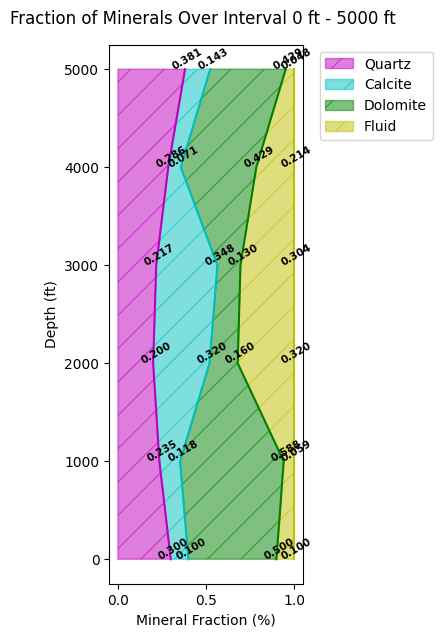

In [67]:
# Colors - quartz, calcite, dolomite, fluid
c = ['m', 'c', 'g', 'y']
labels = ['Quartz', 'Calcite', 'Dolomite', 'Fluid']

# Annotation settings
fontsize = 7.5
fontweight = 'bold'
x_annotation_offset = 0.08
y_annotation_offset = 0.01
annotation_rotation = 30

# Plotting
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((2.5, 7))

fig.suptitle(f'Fraction of Minerals Over Interval {depth[0]} ft - {depth[-1]} ft',
             x=0.5, y=0.93, ha='center')

ax.plot(x_gen[0, :], depth, c=c[0])
ax.fill_betweenx(depth, 0, x_gen[0, :], color=c[0], alpha=0.5, hatch='/', label=labels[0])
sum = x_gen[0, :]

for j, x, y in zip(range(len(depth)), x_gen[0, :], depth):
    plt.annotate(f'{x:.3f}', xy=(sum[j] - x_annotation_offset, y - y_annotation_offset), xycoords='data',
                 fontsize=fontsize, fontweight=fontweight, rotation=annotation_rotation)

for i in range(1, n):
  ax.plot(x_gen[i, :] + sum, depth, c=c[i])
  ax.fill_betweenx(depth, sum, sum + x_gen[i, :], color=c[i], alpha=0.5, hatch='/', label=labels[i])
  sum = sum + x_gen[i, :]

  for j, x, y in zip(range(len(depth)), x_gen[i, :], depth):
    plt.annotate(f'{x:.3f}', xy=(sum[j] - x_annotation_offset, y - y_annotation_offset), xycoords='data',
                 fontsize=fontsize, fontweight=fontweight, rotation=annotation_rotation)


plt.xlabel('Mineral Fraction (%)')
plt.ylabel('Depth (ft)')

plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()
plt.close()

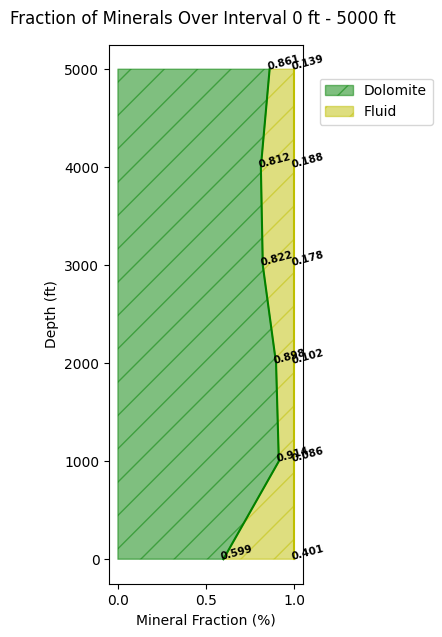

In [68]:
# Colors - quartz, calcite, dolomite, fluid
c = ['m', 'c', 'g', 'y']
labels = ['Quartz', 'Calcite', 'Dolomite', 'Fluid']

# Annotation settings
fontsize = 7.5
fontweight = 'bold'
x_annotation_offset = 0.02
y_annotation_offset = 0.01
annotation_rotation = 15

# Plotting
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((2.5, 7))

fig.suptitle(f'Fraction of Minerals Over Interval {depth[0]} ft - {depth[-1]} ft',
             x=0.5, y=0.93, ha='center')

sum = x_sol[0, :]

if abs(np.sum(x_sol[0, :])) < 0.0001:
  pass
else:
  ax.plot(x_sol[0, :], depth, c=c[0])
  ax.fill_betweenx(depth, 0, x_sol[0, :], color=c[0], alpha=0.5, hatch='/', label=labels[0])

  for j, x, y in zip(range(len(depth)), x_sol[0, :], depth):
    plt.annotate(f'{x:.3f}', xy=(sum[j] - x_annotation_offset, y - y_annotation_offset), xycoords='data',
                  fontsize=fontsize, fontweight=fontweight, rotation=annotation_rotation)

for i in range(1, n):
  if abs(np.sum(x_sol[i, :])) < 0.0001:
    pass
  else:
    ax.plot(x_sol[i, :] + sum, depth, c=c[i])
    ax.fill_betweenx(depth, sum, sum + x_sol[i, :], color=c[i], alpha=0.5, hatch='/', label=labels[i])
    sum = sum + x_sol[i, :]

    for j, x, y in zip(range(len(depth)), x_sol[i, :], depth):
      plt.annotate(f'{x:.3f}', xy=(sum[j] - x_annotation_offset, y - y_annotation_offset), xycoords='data',
                    fontsize=fontsize, fontweight=fontweight, rotation=annotation_rotation)


plt.xlabel('Mineral Fraction (%)')
plt.ylabel('Depth (ft)')

plt.legend(bbox_to_anchor=(1.05, 0.95))

plt.show()
plt.close()

# Pandas + Interactive Plots

In [69]:
path = '/content/drive/MyDrive/Colab Notebooks/PETROTEACH/DATA/DAY 2/SPE_lease_data.csv'

df = pd.read_csv(path)

df.columns = df.columns.str.strip()
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

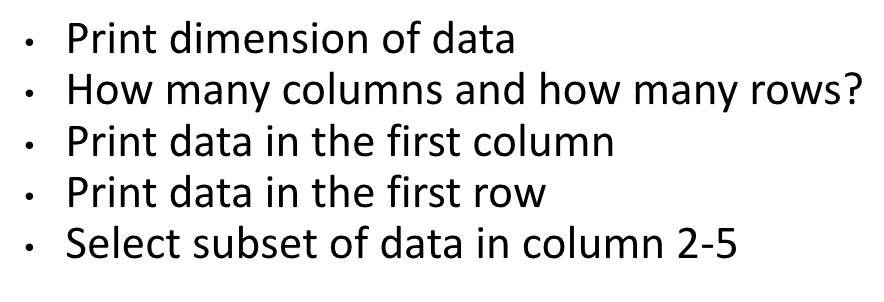

In [70]:
print(f'dimensions of data: {df.shape}', end='\n\n')
print(df.iloc[:5, 0], end='\n\n')
print(df.iloc[0, :5], end='\n\n')
mask = (df['State'] == 'LA') & (df['Initial Pressure Estimate (psi)'] > 5000)
df.iloc[:, 1:5][mask]

dimensions of data: (53, 95)

0    OSPREY
1    FALCON
2      HAWK
3     EAGLE
4      KITE
Name: Lease, dtype: object

Lease                                  OSPREY
Well Number                                 1
State                                      TX
Formation/Reservoir                EAGLE FORD
Initial Pressure Estimate (psi)          5400
Name: 0, dtype: object



,Well Number,State,Formation/Reservoir,Initial Pressure Estimate (psi)
11,62,LA,HAYNESVILLE SHALE,9939
12,63,LA,HAYNESVILLE SHALE,9800
13,64,LA,HAYNESVILLE SHALE,9900
14,65,LA,HAYNESVILLE SHALE,12223
15,66,LA,HAYNESVILLE SHALE,11325
16,67,LA,HAYNESVILLE SHALE,11000
17,68,LA,HAYNESVILLE SHALE,11325
18,69,LA,HAYNESVILLE SHALE,10000
19,70,LA,HAYNESVILLE SHALE,10000
20,71,LA,BOSSIER SHALE,10500


<Axes: >

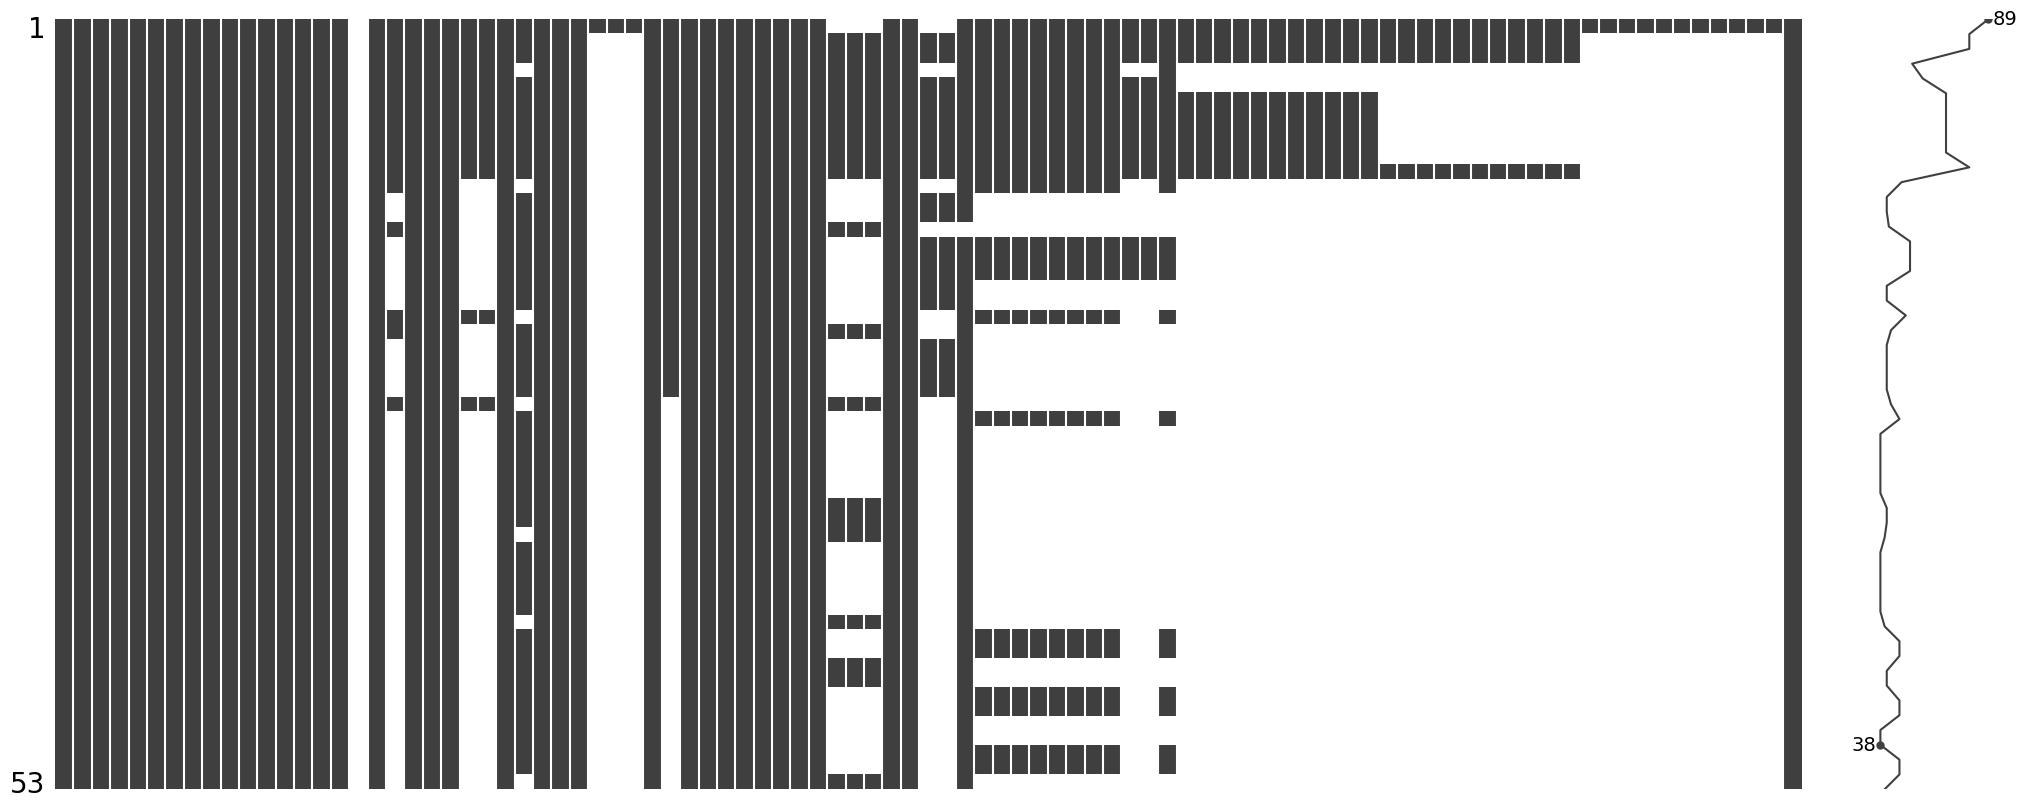

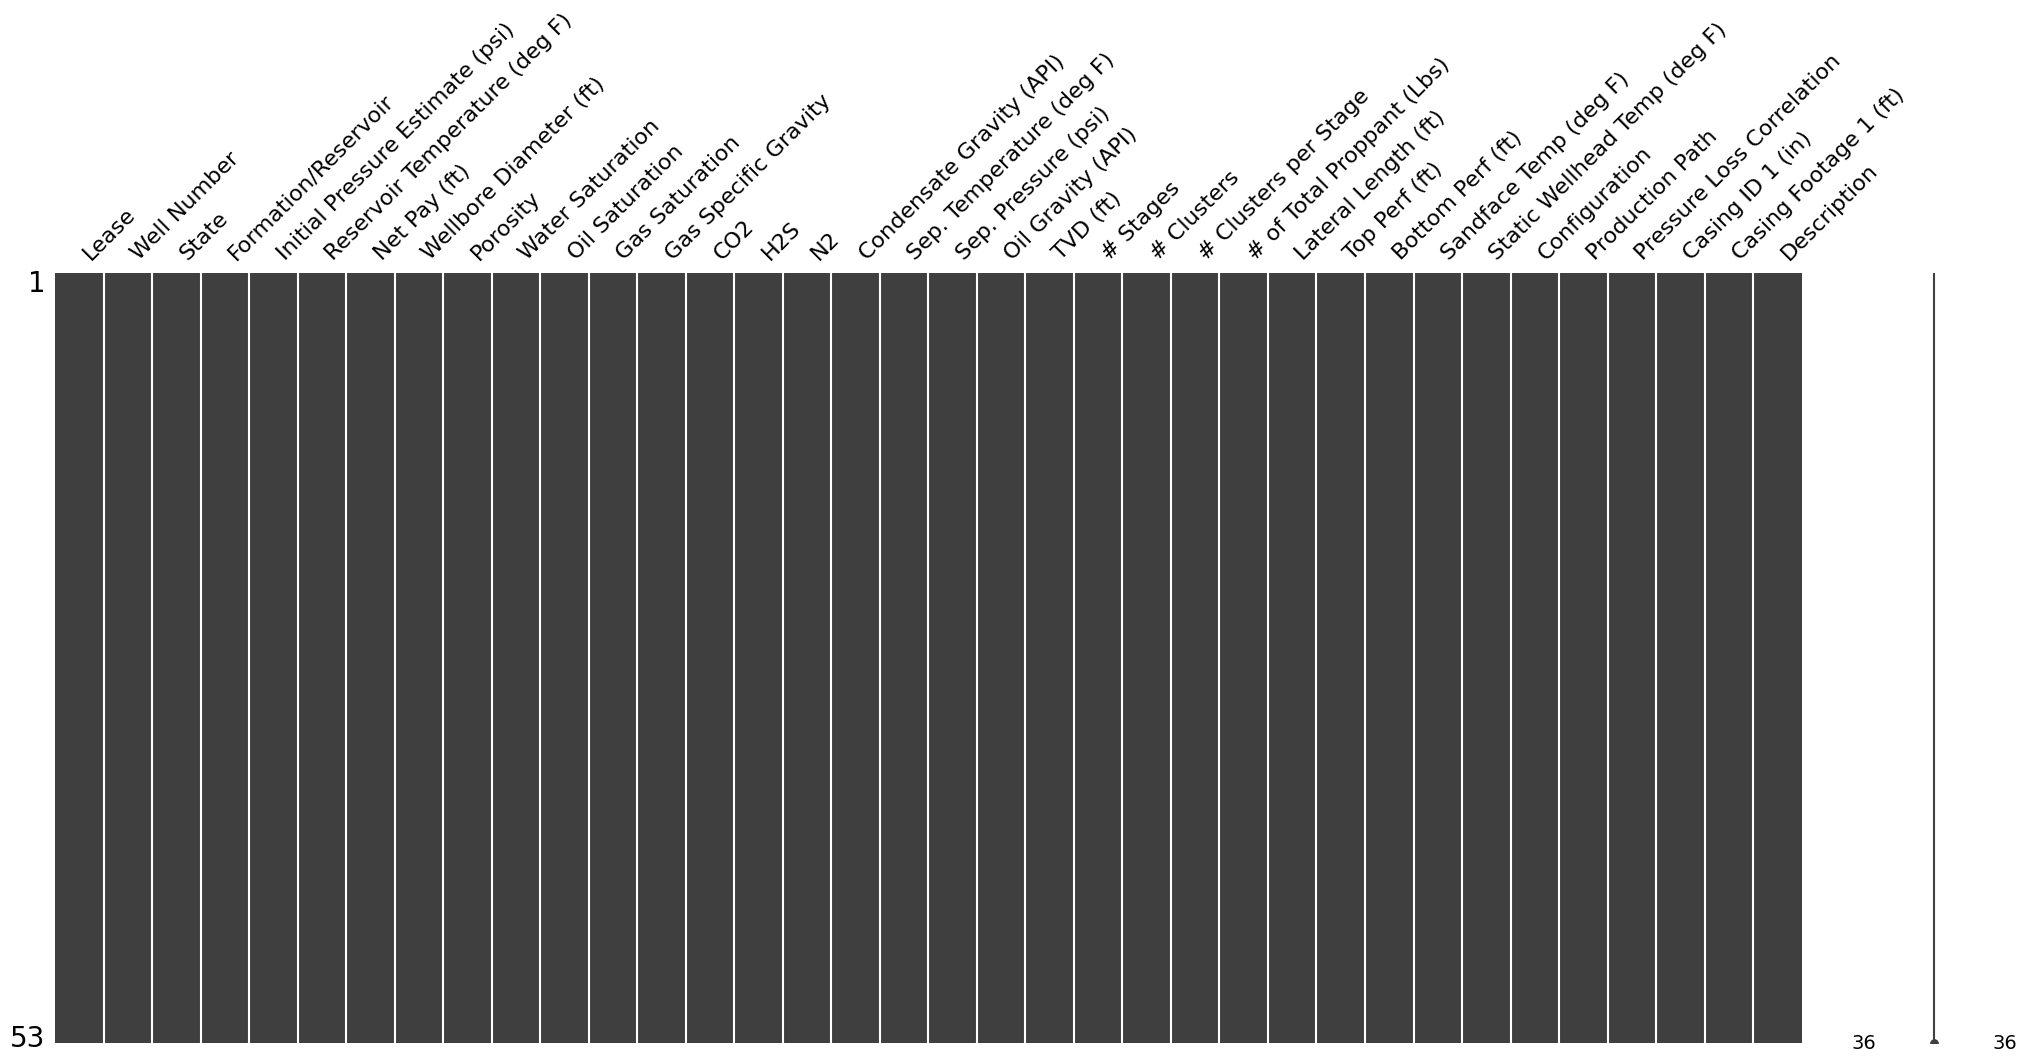

In [71]:
msno.matrix(df)
df_c = df.dropna(axis=1)
msno.matrix(df_c)

<Axes: title={'center': 'Formation/Reservoir'}>

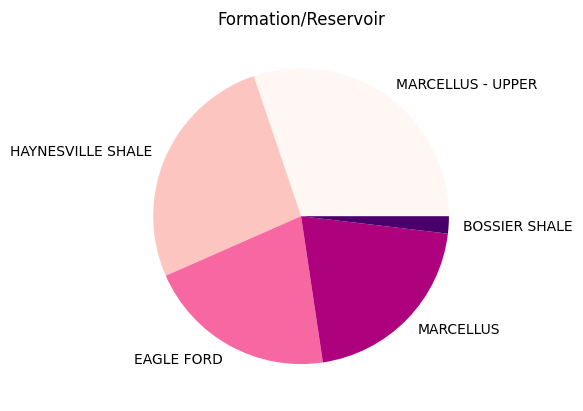

In [72]:
cm = plt.cm.RdPu
df_c['Formation/Reservoir'].value_counts().plot(kind='pie', cmap=cm, title='Formation/Reservoir', label='')

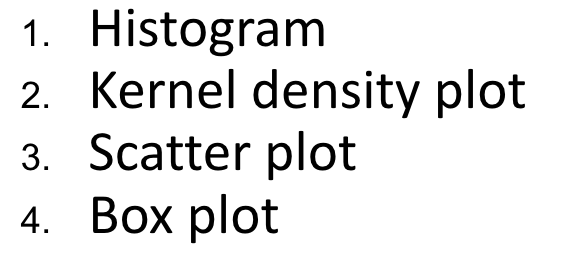

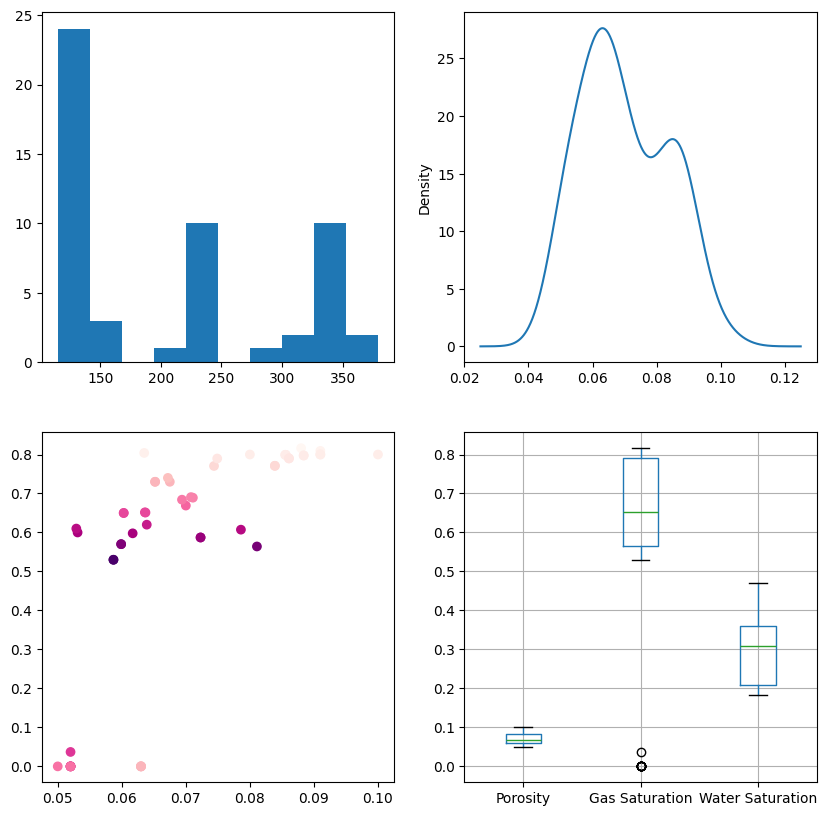

In [73]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches((10, 10))


axs[0, 0].hist(df_c['Sandface Temp (deg F)'])
df_c['Porosity'].plot(kind='kde', ax=axs[0, 1])
axs[1, 0].scatter(df_c['Porosity'], df_c['Gas Saturation'], c=df_c['Water Saturation'], cmap='RdPu')
df_c.boxplot(column=['Porosity', 'Gas Saturation', 'Water Saturation'], ax=axs[1, 1])

plt.show()
plt.close()

In [74]:
df_n = df_c.select_dtypes(np.number)

# for i in range(df_n.shape[1]):
#   print(f'{i}: {df_n.columns[i]}')

delete_cols = [0, 1, 4, 9, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28]
df_t = df_n.drop(columns=df_n.columns[delete_cols])

df_t.corr()

,Reservoir Temperature (deg F),Net Pay (ft),Porosity,Water Saturation,Oil Saturation,Gas Saturation,CO2,N2,Sandface Temp (deg F),Static Wellhead Temp (deg F)
Reservoir Temperature (deg F),1.000000,-0.124106,0.630585,-0.703479,0.088906,0.117283,0.869280,0.180345,0.996453,0.746105
Net Pay (ft),-0.124106,1.000000,0.270686,0.086935,-0.787869,0.714327,-0.013201,-0.304189,-0.125665,0.202327
Porosity,0.630585,0.270686,1.000000,-0.666772,-0.535251,0.692355,0.719763,-0.025433,0.624526,0.688652
Water Saturation,-0.703479,0.086935,-0.666772,1.000000,0.071958,-0.352787,-0.687912,-0.201347,-0.702020,-0.564099
Oil Saturation,0.088906,-0.787869,-0.535251,0.071958,1.000000,-0.958664,-0.100628,0.489822,0.096758,-0.291564
Gas Saturation,0.117283,0.714327,0.692355,-0.352787,-0.958664,1.000000,0.290650,-0.402079,0.109500,0.434453
CO2,0.869280,-0.013201,0.719763,-0.687912,-0.100628,0.290650,1.000000,0.272767,0.868323,0.703636
N2,0.180345,-0.304189,-0.025433,-0.201347,0.489822,-0.402079,0.272767,1.000000,0.182087,0.010658
Sandface Temp (deg F),0.996453,-0.125665,0.624526,-0.702020,0.096758,0.109500,0.868323,0.182087,1.000000,0.739009
Static Wellhead Temp (deg F),0.746105,0.202327,0.688652,-0.564099,-0.291564,0.434453,0.703636,0.010658,0.739009,1.000000


<Axes: >

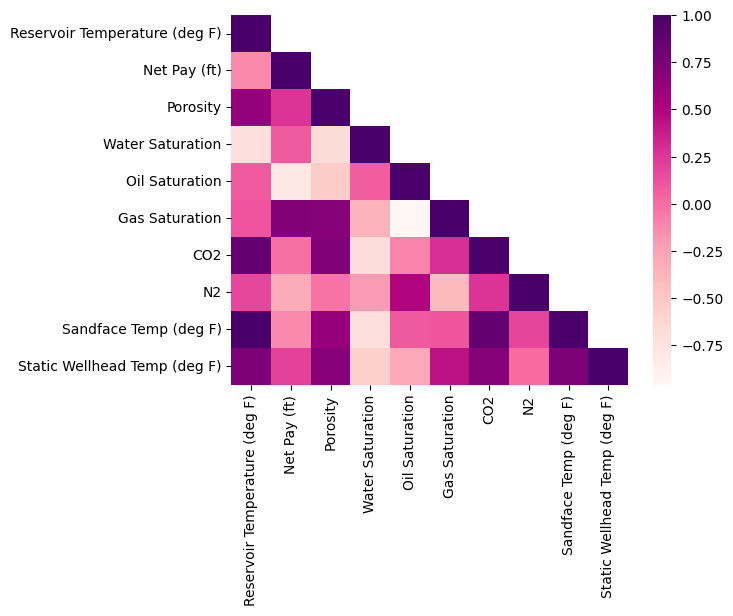

In [75]:
mask = np.triu(np.ones(df_t.corr().shape), k=1)

sns.heatmap(df_t.corr(), cmap='RdPu', mask=mask)

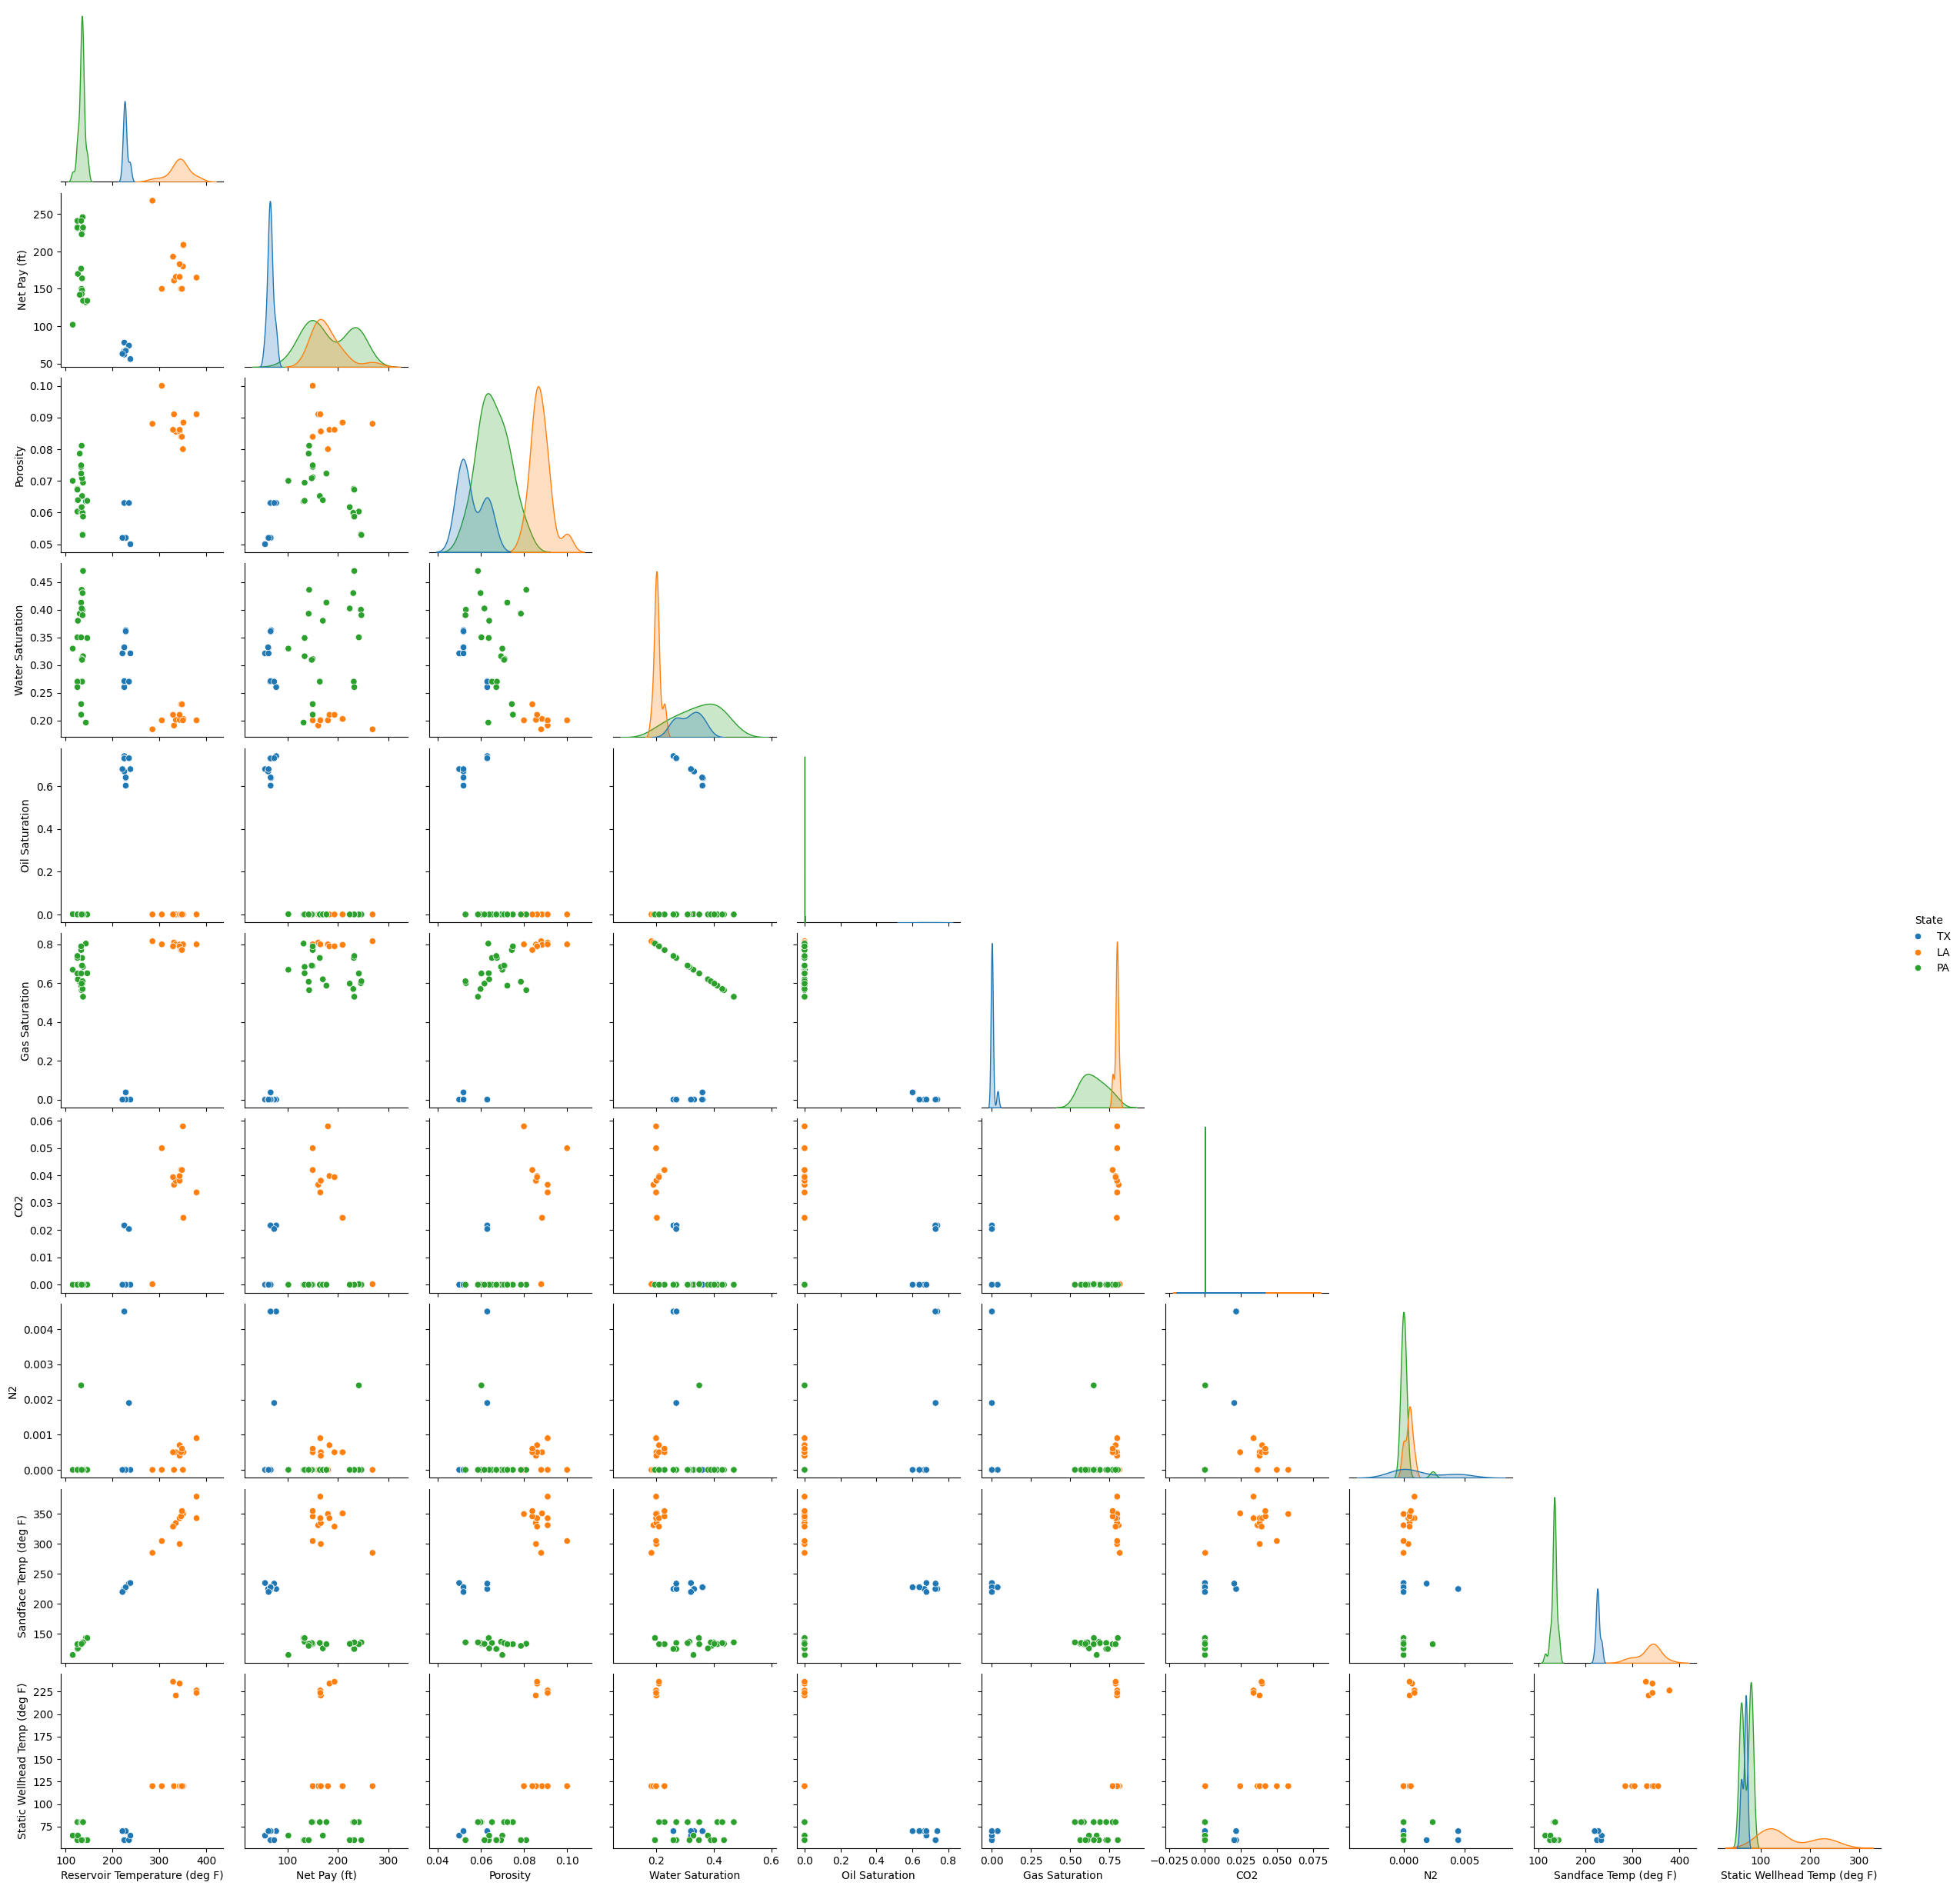

In [76]:
df_s = pd.concat([df_t, df['State']], axis=1)

sns.pairplot(df_s, diag_kind='kde', corner=True, hue='State')

<Axes: >

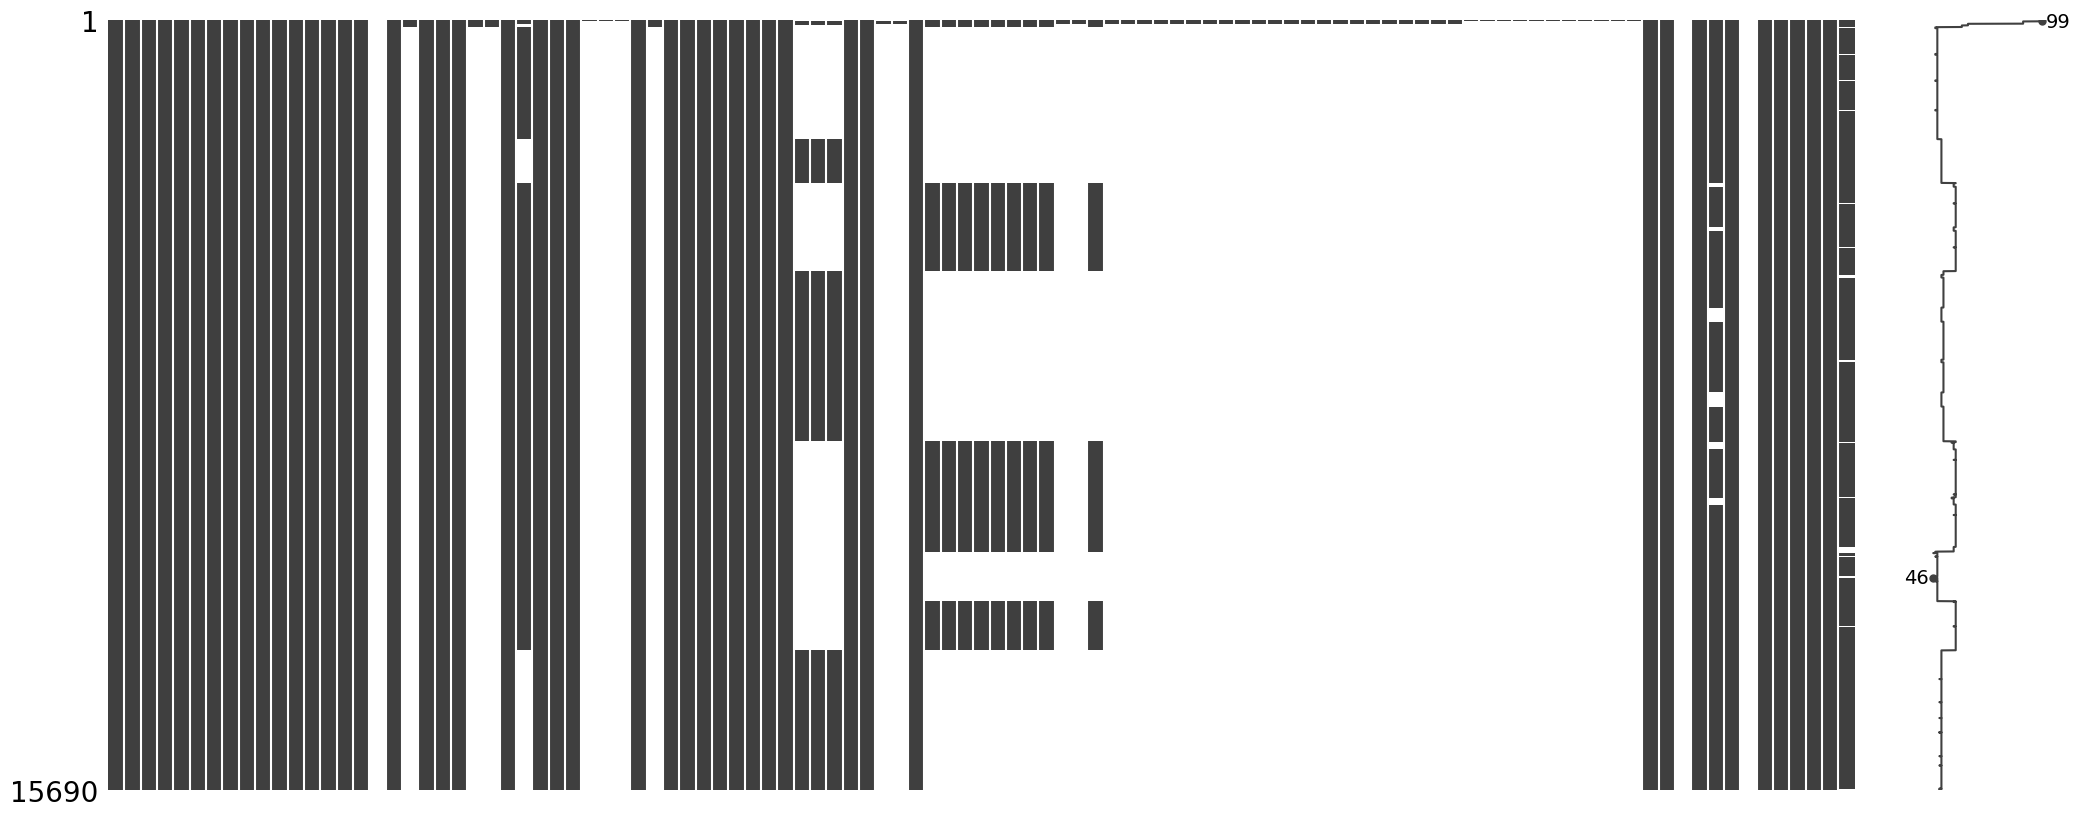

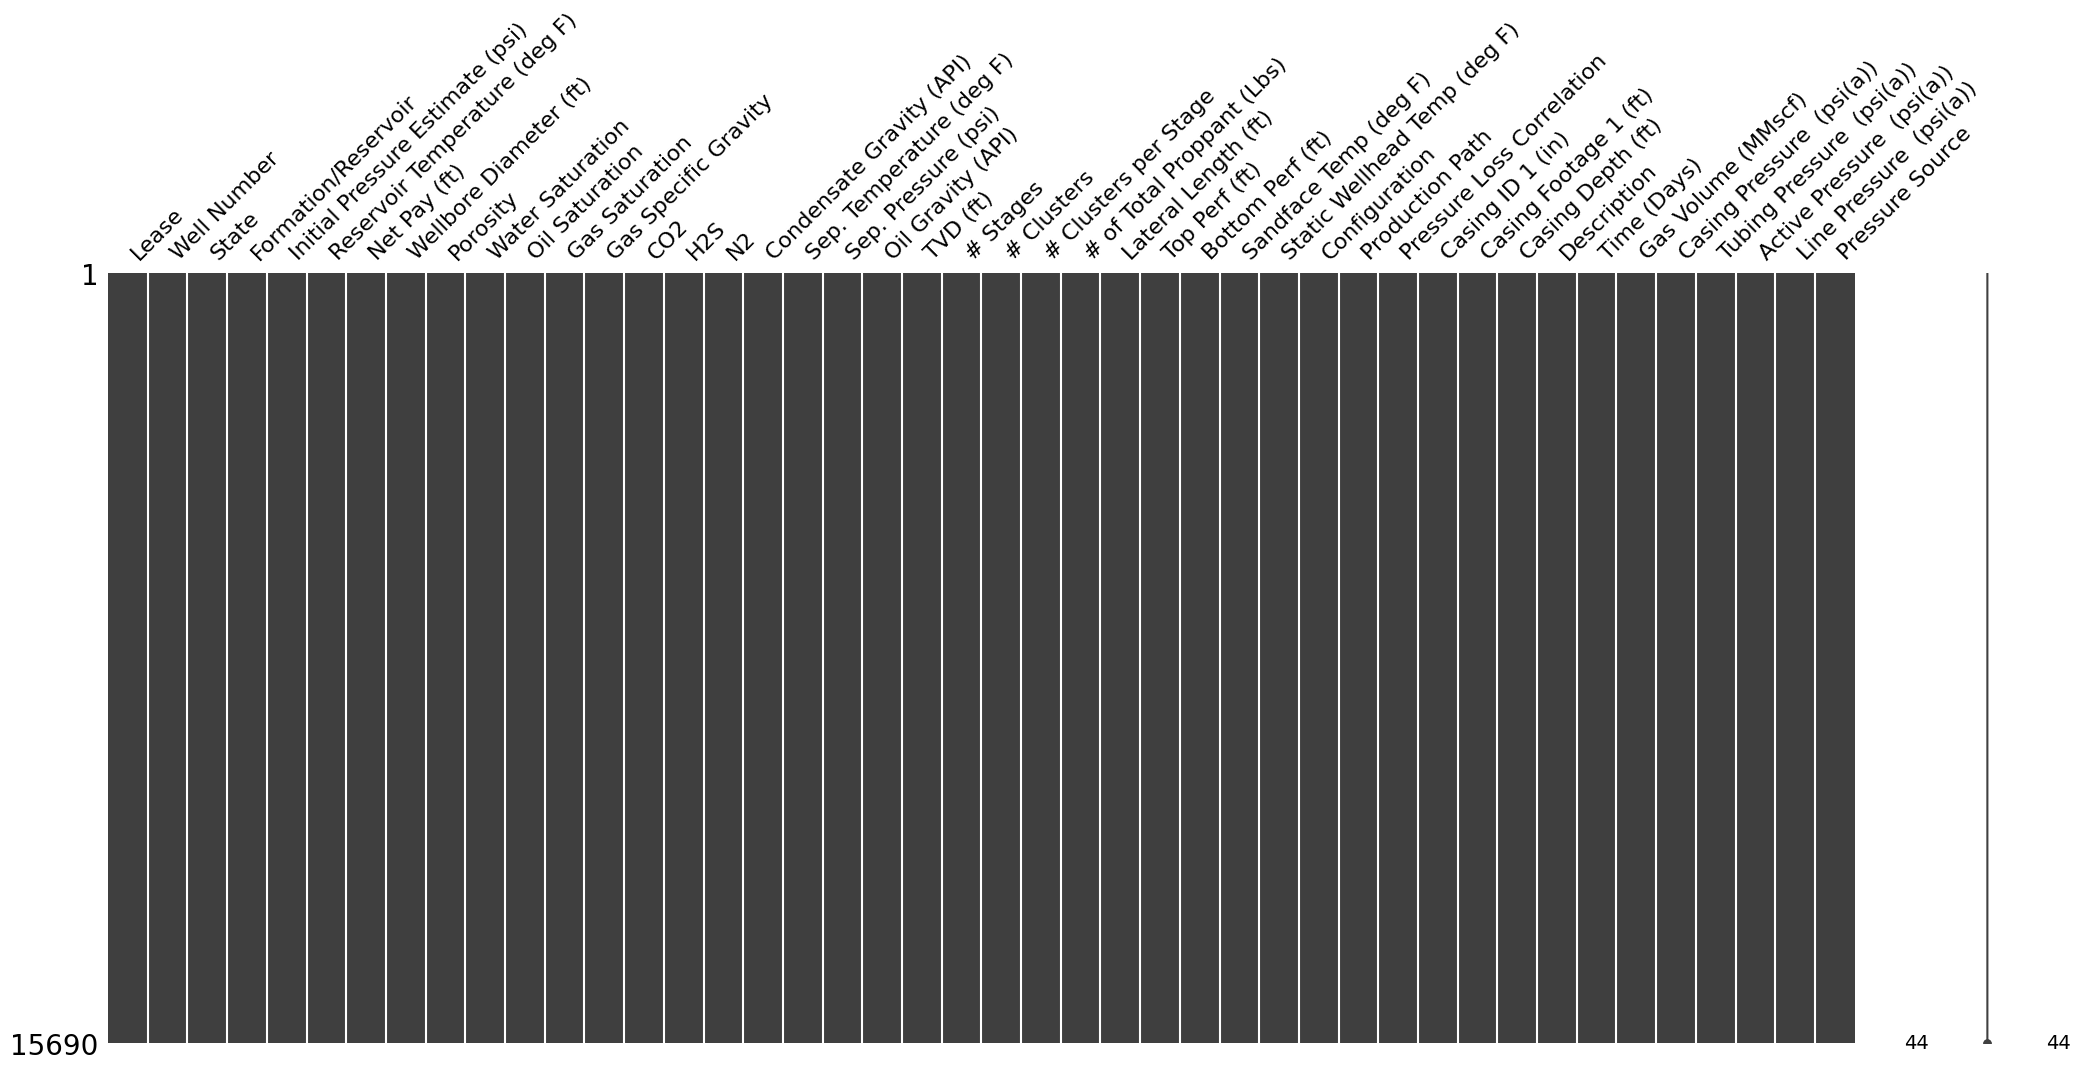

In [77]:
path2 = '/content/drive/MyDrive/Colab Notebooks/PETROTEACH/DATA/DAY 2/SPE_production_data_with_synthetic.csv'

df2 = pd.read_csv(path2)

df2.columns = df2.columns.str.strip()
df2 = df2.map(lambda x: x.strip() if isinstance(x, str) else x)

df_merged = df.merge(df2, on='Lease')

msno.matrix(df_merged)
df_merged_c = df_merged.dropna(axis=1)
msno.matrix(df_merged_c)

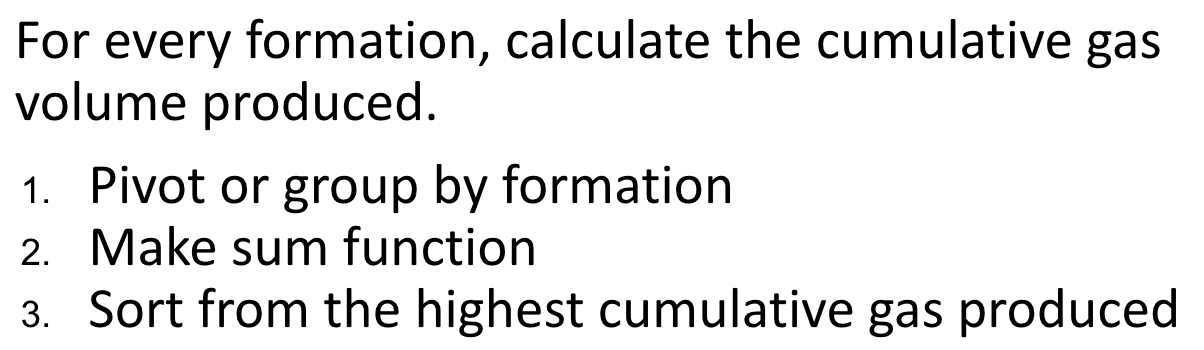

In [78]:
df_merged_c.groupby('Formation/Reservoir')['Gas Volume (MMscf)'].sum().sort_values(ascending=False)

,Gas Volume (MMscf)
Formation/Reservoir,
MARCELLUS - UPPER,83670.19011
EAGLE FORD,1602.16400
BOSSIER SHALE,670.88300


In [79]:
path_volve = '/content/drive/MyDrive/Colab Notebooks/PETROTEACH/DATA/DAY 2/Volve_Production_Data.csv'

volve = pd.read_csv(path_volve)

volve['DATEPRD'] = pd.to_datetime(volve['DATEPRD'], format='%d-%b-%y')
well_name = [x for x in volve['NPD_WELL_BORE_NAME'].unique() if 'F-14' in x]
mask = volve['NPD_WELL_BORE_NAME'] == well_name[0]
f14 = volve[mask].reset_index(drop=True)

f14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATEPRD                   3056 non-null   datetime64[ns]
 1   NPD_WELL_BORE_NAME        3056 non-null   object        
 2   ON_STREAM_HRS             3056 non-null   float64       
 3   AVG_DOWNHOLE_PRESSURE     3050 non-null   float64       
 4   AVG_DOWNHOLE_TEMPERATURE  3050 non-null   float64       
 5   AVG_DP_TUBING             3050 non-null   float64       
 6   AVG_ANNULUS_PRESS         2533 non-null   float64       
 7   AVG_CHOKE_SIZE_P          2860 non-null   float64       
 8   AVG_WHP_P                 3056 non-null   float64       
 9   AVG_WHT_P                 3056 non-null   float64       
 10  DP_CHOKE_SIZE             3056 non-null   float64       
 11  BORE_OIL_VOL              3056 non-null   float64       
 12  BORE_GAS_VOL        

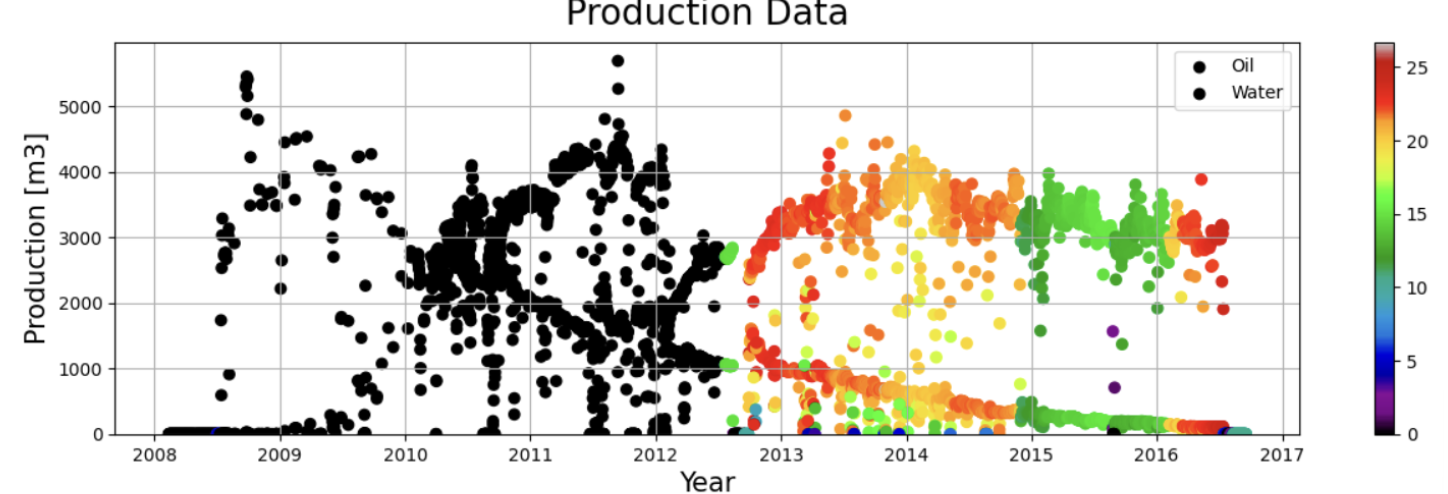

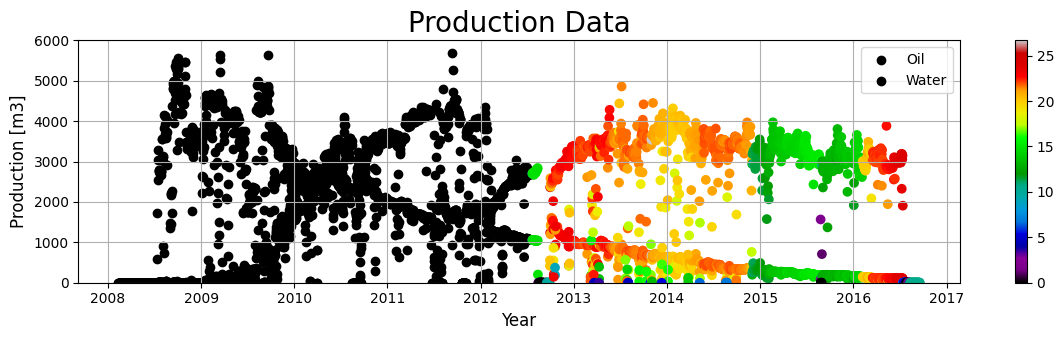

In [80]:
bound = '01-Jun-2012'
mask = f14['DATEPRD'] > bound

fig, ax = plt.subplots(1, 1)
fig.set_size_inches((12, 3.5))

ax.set_title('Production Data', fontdict={'fontsize': 20})
ax.set_ylabel('Production [m3]', fontdict={'fontsize': 12})
ax.set_xlabel('Year', fontdict={'fontsize': 12})

ax.scatter(f14['DATEPRD'][~mask], f14['BORE_OIL_VOL'][~mask], c='k', label='Oil')
ax.scatter(f14['DATEPRD'][~mask], f14['BORE_WAT_VOL'][~mask], c='k', label='Water')
ax.scatter(f14['DATEPRD'][mask], f14['BORE_OIL_VOL'][mask], c=f14['AVG_ANNULUS_PRESS'][mask], cmap='nipy_spectral')
s = ax.scatter(f14['DATEPRD'][mask], f14['BORE_WAT_VOL'][mask], c=f14['AVG_ANNULUS_PRESS'][mask], cmap='nipy_spectral')

ax.set_ylim((0, 6000))

ax.grid()
ax.legend()

plt.colorbar(s)
plt.tight_layout()
plt.show()
plt.close()

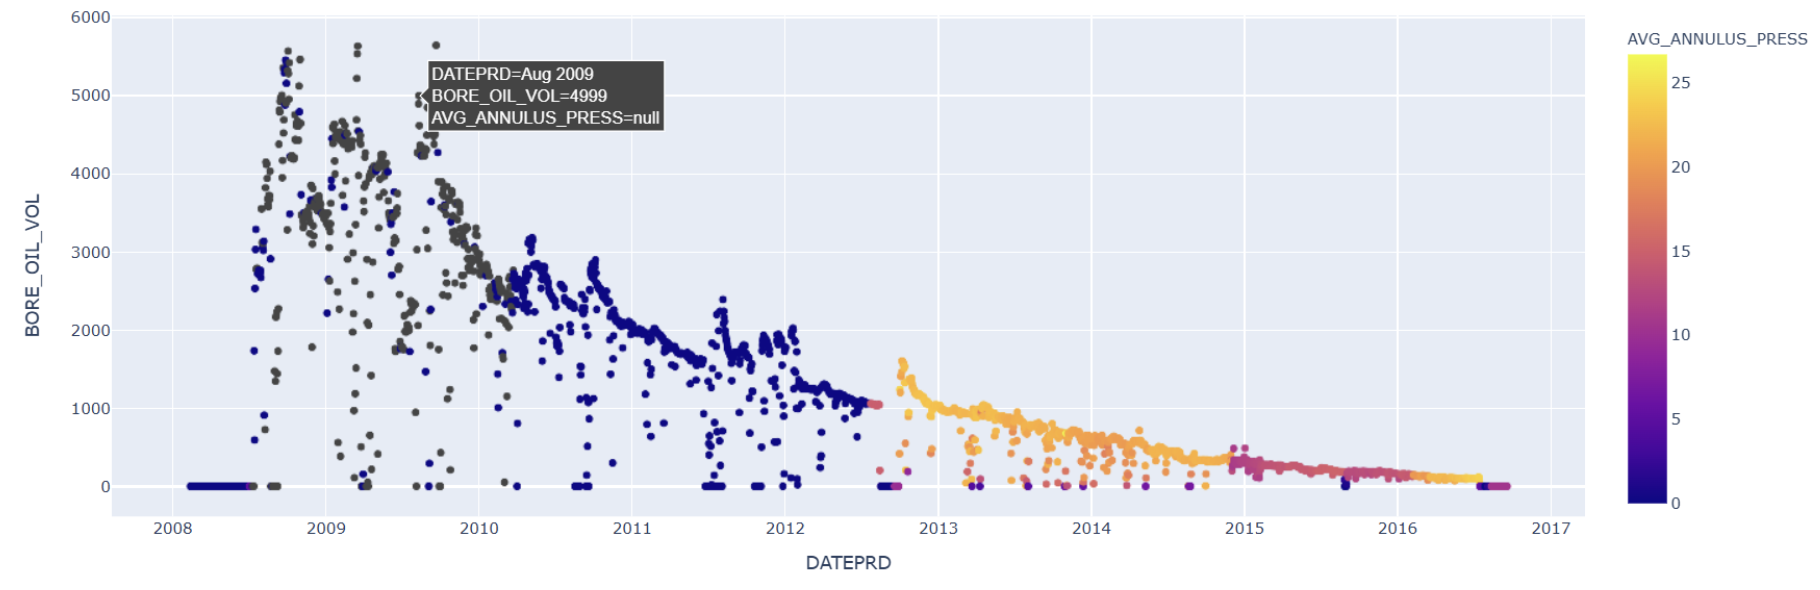

In [81]:
fig = px.scatter(f14, x='DATEPRD', y='BORE_OIL_VOL',
                 width=850, height=300,
                 color='AVG_ANNULUS_PRESS')

fig.update_layout(margin={'t': 10, 'b': 10, 'l': 10, 'r': 10})

fig.show()

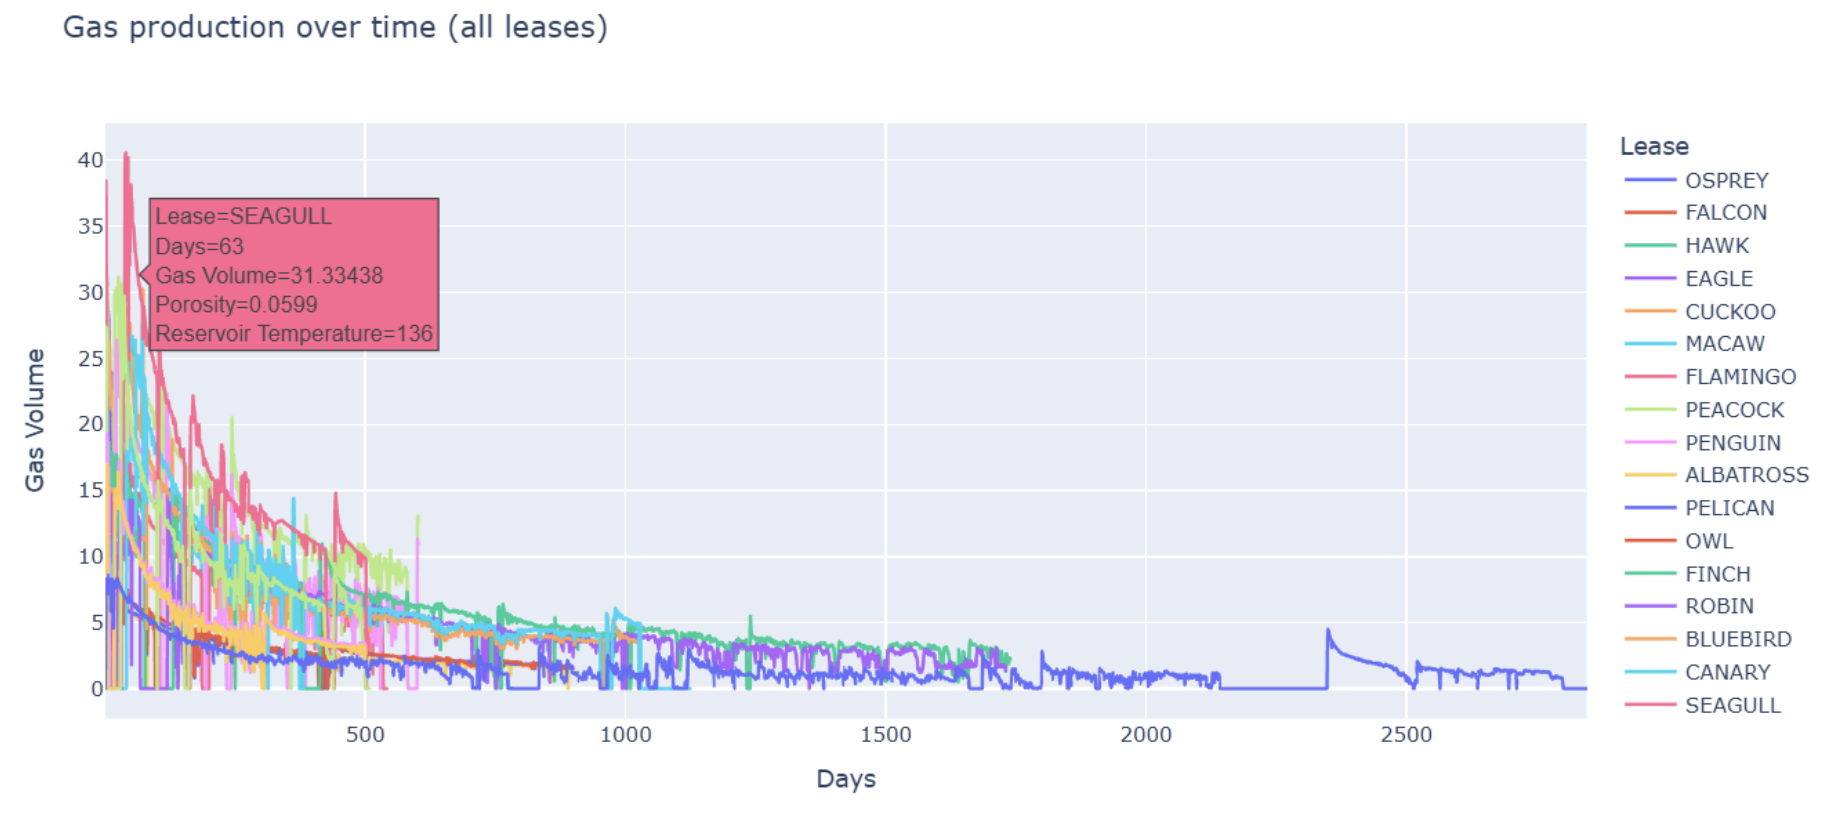

In [82]:
fig = px.line(df_merged_c, x='Time (Days)', y="Gas Volume (MMscf)", color="Lease",
              width=900, height=400,
              hover_data=['Porosity', 'Reservoir Temperature (deg F)'],
              title="Gas production over time (all leases)")

fig.update_layout(margin={'t': 50, 'b': 10, 'l': 10, 'r': 10})

fig.show()